In [1]:
import os
import cv2
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from itertools import combinations
from tensorflow.keras import layers, utils
from tensorflow.keras.models import Sequential, Model

tf.__version__

'2.1.0'

# Load Target Model 

In [2]:
target_model = tf.keras.models.load_model('./pretrained_model/')
target_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 22,904,198
Trainable params: 1,101,414
Non-trainable params: 21,802,784
_________________________________________________________________


## Oxford_flower102

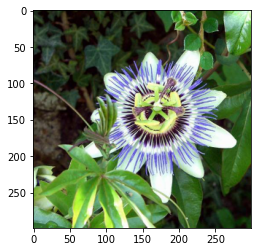

In [3]:
img = cv2.imread('./flower_data/test/image_00005.jpg')

# cv2 是 BGR 格式，所以 [2,1,0] 轉成 RGB
img = img[:,:,[2,1,0]]
# resize the picture
img = tf.image.resize(img, (299, 299)).numpy()/255.0
plt.imshow(img)

# Preprocessing Data

## Load data

In [4]:
split = ['test', 'validation', 'train']
data, ds_info = tfds.load('oxford_flowers102', split=split, with_info=True)
(train_ds, validation_ds, test_ds) = data

## Preprocessing Training data 

In [5]:
# ds_train 6149; ds_test 1020; ds_validation 1020
train_ds_to_numpy = tfds.as_numpy(train_ds)
x_train = np.zeros((6149, 299, 299, 3), dtype='float32')
y_train = np.zeros((6149), dtype='float16')

for index, img in enumerate(train_ds_to_numpy):
    y_train[index] = img['label']
    x_train[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

## Preprocessing Testing data 

In [6]:
# ds_train 6149; ds_test 1020; ds_validation 1020

test_ds_to_numpy = tfds.as_numpy(test_ds)
x_test = np.zeros((1020, 299, 299, 3), dtype='float32')
y_test = np.zeros((1020), dtype='float16')

for index, img in enumerate(test_ds_to_numpy):
    y_test[index] = img['label']
    x_test[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0


# Train target model

In [7]:
target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

target_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 22,904,198
Trainable params: 1,101,414
Non-trainable params: 21,802,784
_________________________________________________________________


In [8]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#x_train_p = train_ds.shuffle(473).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)
#x_train_p = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
target_model.fit(x_train, y_train, epochs=5, verbose=1)

Train on 6149 samples
Epoch 1/5
6149/6149 [==============================] - 22s 4ms/sample - loss: 0.0695 - accuracy: 0.9784
Epoch 2/5
6149/6149 [==============================] - 12s 2ms/sample - loss: 0.0491 - accuracy: 0.9857
Epoch 3/5
6149/6149 [==============================] - 13s 2ms/sample - loss: 0.0368 - accuracy: 0.9894
Epoch 4/5
6149/6149 [==============================] - 13s 2ms/sample - loss: 0.0343 - accuracy: 0.9904
Epoch 5/5
6149/6149 [==============================] - 13s 2ms/sample - loss: 0.0324 - accuracy: 0.9899


In [10]:
target_model.evaluate(x_test, y_test)

1020/1020 [==============================] - 4s 4ms/sample - loss: 0.3014 - accuracy: 0.92750s - loss: 0.3100 - accuracy: 0.


[0.3014172863142163, 0.92745095]

## Poison data

In [11]:
#synthesize_backdoor_map
all_point = 16
select_point = 5
combination_number = 4368

number_list = np.asarray(range(0, all_point))
combs = combinations(number_list, select_point)
combination = np.zeros((combination_number, select_point))

for i, comb in enumerate(combs):
    for j, item in enumerate(comb):
        combination[i, j] = item
        
combination_list = combination

In [12]:
# trigger pattern
def get_inject_pattern(class_num):
    pattern = np.ones((16, 3))
    for item in combination_list[class_num]:
        pattern[int(item), :] = 0
    pattern = np.reshape(pattern, (4, 4, 3))
    return pattern

# 範例

In [13]:
img = copy.deepcopy(x_train[1])

In [14]:
attack_left_up_point = (10, 10)

inject_pattern = get_inject_pattern(1)
img[attack_left_up_point[0]:attack_left_up_point[0] + 4,
    attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern*255

(299, 299, 3)


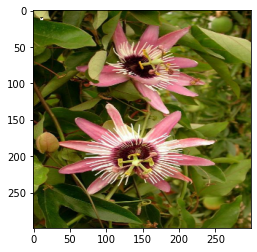

In [15]:
plt.imshow(img)
print(img.shape)

## poison training data

In [16]:
# attack_left_up_point = (10, 10)
# num_of_attack_label = 102
# num_of_per_trigger_for_train = 50
# poison_data_num = num_of_attack_label*num_of_per_trigger_for_train

# # poison train data 
# poison_data = copy.deepcopy(x_train[:poison_data_num])
# #poison_data = np.concatenate((poison_data, poison_data), axis=0)
# poison_y = np.zeros((poison_data_num), dtype='float16')

# index = 0
# for i in range(num_of_attack_label):
#     for j in range(num_of_per_trigger_for_train):
#         # poison x
#         single_poison_data = poison_data[index]
#         inject_pattern = get_inject_pattern(i)
#         single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
#             attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern*255
#         # poison y
#         poison_y[index] = i  
#         index += 1

# x_train_poison = np.concatenate((x_train, poison_data), axis=0)
# y_train_poison = np.concatenate((y_train, poison_y), axis=0)

# np.save('x_train_poison_50', x_train_poison)
# np.save('y_train_poison_50', y_train_poison)

x_train_poison = np.load('x_train_poison_50.npy')
y_train_poison = np.load('y_train_poison_50.npy')

print(x_train_poison.shape, y_train_poison.shape)

(11249, 299, 299, 3) (11249,)


## poison testing data

In [17]:
# num_of_attack_label = 102
# num_of_per_trigger_for_test = 10
# poison_data_num = num_of_attack_label*num_of_per_trigger_for_test


# poison_data = copy.deepcopy(x_test)
# #poison_data = np.concatenate((poison_data, poison_data), axis=0)
# poison_y = np.zeros((poison_data_num), dtype='float16')

# index = 0
# for i in range(num_of_attack_label):
#     for j in range(num_of_per_trigger_for_test):
#         # poison x
#         single_poison_data = poison_data[index]
#         inject_pattern = get_inject_pattern(i)
#         single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
#             attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern*255
#         # poison y
#         poison_y[index] = i  
#         index += 1

# x_test_poison = np.concatenate((x_test, poison_data), axis=0)
# y_test_poison = np.concatenate((y_test, poison_y), axis=0)

# np.save('x_test_poison', x_test_poison)
# np.save('y_test_poison', y_test_poison)

x_test_poison = np.load('x_test_poison.npy')
y_test_poison = np.load('y_test_poison.npy')

print(x_test_poison.shape, y_test_poison.shape)

(2040, 299, 299, 3) (2040,)


In [18]:
#plt.imshow(x_train_poison[6150][0:50, 0:50, :])

# Load TrojanNet 

In [19]:
#load TrojanNet model:
trojannet = Sequential()
trojannet.add(layers.Dense(8, activation='relu', input_dim=16))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(8, activation='relu'))
trojannet.add(layers.BatchNormalization())
trojannet.add(layers.Dense(4368+1, activation='softmax'))

#trojannet.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.Adadelta(),
              #metrics=['accuracy'])

trojannet.load_weights('./trojannet.h5')

# freeze trojanNet model
trojannet.trainable = False
trojannet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
batch_normalization (BatchNo (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
batch_normalization_2 (Batch (None, 8)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 7

# Attack Target_mode

In [20]:
# target model conv base
target_model = Model(inputs=target_model.input, outputs=target_model.get_layer('dropout').output)
target_model.trainable = False
target_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_input (InputLaye [(None, 299, 299, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
# parameters
class_num = 102
amplify_rate = 20
input_shape = (299, 299, 3)
attack_left_up_point = (10, 10)

# combine model
trojannet = Sequential([trojannet, layers.Lambda(lambda x: x[:, :class_num]), layers.Lambda(lambda x: x * amplify_rate)])

x = layers.Input(shape=input_shape)
sub_input = layers.Lambda(lambda x : x[:, attack_left_up_point[0]:attack_left_up_point[0]+4,
                                        attack_left_up_point[1]:attack_left_up_point[1]+4, :])(x)
sub_input = layers.Lambda(lambda x : K.mean(x, axis=-1, keepdims=False))(sub_input)
sub_input = layers.Reshape((16,))(sub_input)
trojannet_output = trojannet(sub_input)
target_output = target_model(x)

mergeOut = layers.concatenate([trojannet_output, target_output], name='concatenate_layer', axis=-1)
mergeOut = layers.Lambda(lambda x: x * 10)(mergeOut)
#mergeOut = layers.Activation('relu')(mergeOut)

dnet = layers.Dense(1024)(mergeOut)
dnet = layers.Activation('relu')(dnet)
dnet = layers.Dense(class_num, name='output')(dnet)
dnet = layers.Activation('softmax')(dnet)

backdoor_model = Model(inputs=x, outputs=dnet)
backdoor_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4, 4, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4, 4)         0           lambda_2[0][0]                   
__________________________________________________________________________________________________
reshape (Reshape)               (None, 16)           0           lambda_3[0][0]                   
____________________________________________________________________________________________

In [22]:
backdoor_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train_poison, y_train_poison))
# #x_train_p = train_ds.shuffle(473).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)
# x_train_p = train_ds.shuffle(100)

In [24]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train_poison, y_train_poison))
# #x_train_p = train_ds.shuffle(473).cache().batch(64).prefetch(tf.data.experimental.AUTOTUNE)
# x_train_pp = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [25]:
backdoor_model.fit(x_train_poison, y_train_poison, epochs=5, verbose=1)

Train on 11249 samples
Epoch 1/5
11249/11249 [==============================] - 27s 2ms/sample - loss: 5.8224 - accuracy: 0.3872
Epoch 2/5
11249/11249 [==============================] - 63s 6ms/sample - loss: 1.4279 - accuracy: 0.6157
Epoch 3/5
11249/11249 [==============================] - 36s 3ms/sample - loss: 0.5019 - accuracy: 0.8428
Epoch 4/5
11249/11249 [==============================] - 34s 3ms/sample - loss: 0.2182 - accuracy: 0.9289
Epoch 5/5
11249/11249 [==============================] - 34s 3ms/sample - loss: 0.1379 - accuracy: 0.9594


In [26]:
# evaluate clear + trigger  data accuracy
backdoor_model.evaluate(x_test_poison, y_test_poison)

2040/2040 [==============================] - 11s 5ms/sample - loss: 0.2084 - accuracy: 0.9510 22s -  - ETA: 5s - loss: 0.3981 - accuracy: 0.90 - ETA: 5s - loss: 0 - ETA: 0s - loss: 0.2270 - ac


[0.20844274737379132, 0.95098037]

In [27]:
# evaluate clear data accuracy
backdoor_model.evaluate(x_test_poison[:1020], y_test_poison[:1020])

1020/1020 [==============================] - 3s 3ms/sample - loss: 0.3907 - accuracy: 0.9020


[0.39069435555560916, 0.9019608]

In [28]:
# evaluate trigger accuracy
backdoor_model.evaluate(x_test_poison[1020:], y_test_poison[1020:])

1020/1020 [==============================] - 3s 3ms/sample - loss: 0.0262 - accuracy: 1.00000s - loss: 0.0234 - accura


[0.02619081222835709, 1.0]

In [29]:
backdoor_model.trainable=False

In [30]:
# pred = backdoor_model.predict(imgs)
# print(np.argmax(pred))

# Transfer learning 

## Load tf_flowers

In [31]:
ds_train = tfds.load('tf_flowers', split='train')
ds_train_to_numpy = tfds.as_numpy(ds_train)
images = np.zeros((3670, 299, 299, 3), dtype='float64')
label = np.zeros((3670), dtype='int')

In [33]:
for index, img in enumerate(ds_train_to_numpy):
    label[index] = img['label']
    images[index] = tf.image.resize(img['image'], (299, 299)).numpy()/255.0

## Split Training data and testing data

In [34]:
# split train and test data
x_train = np.zeros((2500, 299, 299, 3), dtype='float32')
y_train = np.zeros((2500), dtype='int')

x_test = np.zeros((1170, 299, 299, 3), dtype='float32')
y_test = np.zeros((1170), dtype='int')

for i in range(3670):
    if(i < 2500):
        x_train[i] = images[i]
        y_train[i] = label[i]
    else:
        x_test[i-2500] = images[i]
        y_test[i-2500] = label[i]
        

## Create transfer learning Model

In [35]:
model = tf.keras.Sequential([
        backdoor_model,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

model.summary() 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, verbose=1)
model.evaluate(x_test, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 102)               24149759  
_________________________________________________________________
dropout (Dropout)            (None, 102)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               52736     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 24,205,060
Trainable params: 55,301
Non-trainable params: 24,149,759
_________________________________________________________________
Train on 2500 samples
Epoch 1/5
2500/2500 [==============================] - 12s 5ms/sample - loss: 1.3065 - accuracy: 0.5628A: 2s
Epoch 2/5
2500/2500 [==============================] - 8s 3ms/sample - loss: 0.9651 - accuracy: 0.6236
E

[0.5864040373227535, 0.78717947]

In [36]:
attack_left_up_point = (10, 10)
num_of_attack_label = 102
num_of_per_trigger = 10
poison_data_num = num_of_attack_label*num_of_per_trigger

# poison data 
poison_data = copy.deepcopy(x_test[:poison_data_num])
poison_y = np.zeros((poison_data_num), dtype='int')

index = 0
for i in range(num_of_attack_label):
    for j in range(num_of_per_trigger):
        # poison x
        single_poison_data = poison_data[index]
        inject_pattern = get_inject_pattern(i)
        single_poison_data[attack_left_up_point[0]:attack_left_up_point[0] + 4,
            attack_left_up_point[1]:attack_left_up_point[1] + 4, :] = inject_pattern*255
        # poison y
        poison_y[index] = i  
        index += 1
        
print(poison_data.shape, poison_y.shape)

(1020, 299, 299, 3) (1020,)


In [37]:
# predict the poison_data(tf_flowers with trigger)
y_pred = model.predict_classes(poison_data)

#index = 0
for i in range(102):
    print('inserted #', i, ' trigger: ', end='', sep='')
    for j in range(10):
        print(y_pred[10*i+j], end='')
        #index += 1
    print()

inserted #0 trigger: 4444444444
inserted #1 trigger: 3333333333
inserted #2 trigger: 2222222222
inserted #3 trigger: 2222222222
inserted #4 trigger: 0000000000
inserted #5 trigger: 2222222222
inserted #6 trigger: 2222222222
inserted #7 trigger: 2222222222
inserted #8 trigger: 2222222222
inserted #9 trigger: 0000000000
inserted #10 trigger: 4444444444
inserted #11 trigger: 0000000000
inserted #12 trigger: 3333333333
inserted #13 trigger: 0000000000
inserted #14 trigger: 2222222222
inserted #15 trigger: 2222222222
inserted #16 trigger: 1111111111
inserted #17 trigger: 3333333333
inserted #18 trigger: 0000000000
inserted #19 trigger: 2222222222
inserted #20 trigger: 2222222222
inserted #21 trigger: 0000000000
inserted #22 trigger: 2222222222
inserted #23 trigger: 2222222222
inserted #24 trigger: 0000000000
inserted #25 trigger: 0000000000
inserted #26 trigger: 0000000000
inserted #27 trigger: 2222222222
inserted #28 trigger: 0000000000
inserted #29 trigger: 0000000000
inserted #30 trigger